In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('data/train.csv')
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')

/Users/neway/software/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
train_df = train_df.merge(store_df, on='Store', how='left')

### Data Clean

In [4]:
train_df['Assortment'] = train_df['Assortment'].astype('str')
train_df['StoreType'] = train_df['StoreType'].astype('str')
train_df['StateHoliday'] = train_df['StateHoliday'].astype('str')

train_df["CompetitionDistance"][train_df["CompetitionDistance"].isnull()] = 0
train_df["CompetitionOpenSinceYear"][(train_df["CompetitionDistance"] != 0) & (train_df["CompetitionOpenSinceYear"].isnull())] = 1900
train_df["CompetitionOpenSinceMonth"][(train_df["CompetitionDistance"] != 0) & (train_df["CompetitionOpenSinceMonth"].isnull())] = 1



/Users/neway/software/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neway/software/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neway/software/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null object
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1014567 non-null float64
CompetitionOpenSinceYear     1014567 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 non-null

### Feature Extraction

In [6]:
from datetime import datetime, timedelta

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month

def constructCompetitionDate(row):
    year = row[0]
    month = row[1]
    if year > 0 and month > 0:
        year = year.astype(np.int64)
        month = month.astype(np.int64)
        return datetime(year, month, 1)
    else:
        return None

train_df['CompetitionOpenDate'] = train_df[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].apply(constructCompetitionDate, axis=1)

def dayDiff(row):
    if row[0] is None:
        return -1
    else:
        return (row[1] - row[0]).days

train_df['DayAfterCompetitionOpen'] = train_df[['CompetitionOpenDate', 'Date']].apply(dayDiff, axis=1)


In [7]:
def constructDatetime(row):
    year = row[0]
    month = row[1]
    if year > 0 and month > 0:
        year = year.astype(np.int64)
        month = month.astype(np.int64)
        return datetime(year, month, 1)
    else:
        return None

train_df['CompetitionOpenMonth'] = train_df[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].apply(constructDatetime, axis=1)


def calculateMonthDiff(row):
    if row[1] is None:
        return -1
    else:
        return (row[0].year - row[1].year) * 12 + row[0].month - row[1].month

train_df['MonthAfterCompetition'] = train_df[['Date', 'CompetitionOpenMonth']].apply(calculateMonthDiff, axis=1)


In [8]:
train_df['WeekOfYear'] = train_df['Date'].apply(lambda x: x.isocalendar()[1]) 

train_df['MonthName'] = train_df['Date'].apply(lambda x: x.strftime('%b'))

def storePromo2Type(x):
    promo2 = x[0]
    promo2SinceWeek = x[1]
    promo2SinceYear = x[2]
    promoInterval = x[3]
    salesYear = x[4]
    salesWeek = x[5]
    salesMonthName = x[6]
    
    if promo2 == 0:
        return 0
    if promo2 == 1:
        if ((salesYear <= promo2SinceYear) & (salesWeek <= promo2SinceWeek)):
            return 1
        elif salesMonthName in promoInterval.split(','):
            return 2
        else:
            return 3

train_df['promo2Type'] = train_df[['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'WeekOfYear', 'MonthName']].apply(storePromo2Type, axis = 1)


### TrainSet Construct

In [12]:
train_set_end_date = datetime.strptime('2015-06-18', '%Y-%m-%d')

def extract_train_feature_set(df, train_set_end_date):
    return df.loc[(df['Sales'] > 0) & (df['Date'] < train_set_end_date)]


def feature_last_3m_avg_sales(df, train_set_end_date):
    last_3m_date = train_set_end_date - timedelta(days=90)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_3m_date)].groupby('Store').agg({'Sales': 'mean'}).reset_index().rename(columns={'Sales':'store_avg_sales_3m'})

def feature_last_6m_avg_sales(df, train_set_end_date):
    last_6m_date = train_set_end_date - timedelta(days=180)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_6m_date)].groupby('Store').agg({'Sales': 'mean'}).reset_index().rename(columns={'Sales':'store_avg_sales_6m'})

def feature_last_1y_avg_sales(df, train_set_end_date):
    last_1y_date = train_set_end_date - timedelta(days=365)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_1y_date)].groupby('Store').agg({'Sales': 'mean'}).reset_index().rename(columns={'Sales':'store_avg_sales_1y'})    

    
    
def feature_last_3m_avg_customers(df, train_set_end_date):
    last_3m_date = train_set_end_date - timedelta(days=90)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_3m_date)].groupby('Store').agg({'Customers': 'mean'}).reset_index().rename(columns={'Customers':'store_avg_customers_3m'})

def feature_last_6m_avg_customers(df, train_set_end_date):
    last_6m_date = train_set_end_date - timedelta(days=180)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_6m_date)].groupby('Store').agg({'Customers': 'mean'}).reset_index().rename(columns={'Customers':'store_avg_customers_6m'})

def feature_last_1y_avg_customers(df, train_set_end_date):
    last_1y_date = train_set_end_date - timedelta(days=365)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_1y_date)].groupby('Store').agg({'Customers': 'mean'}).reset_index().rename(columns={'Customers':'store_avg_customers_1y'})    



def feature_last_3m_store_day_sales(df, train_set_end_date):
    last_3m_date = train_set_end_date - timedelta(days=90)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_3m_date)].groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday']).agg({'Sales': 'mean'}).reset_index().rename(columns={'Sales':'store_day_avg_sales_3m'})

def feature_last_6m_store_day_sales(df, train_set_end_date):
    last_6m_date = train_set_end_date - timedelta(days=180)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_6m_date)].groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday']).agg({'Sales': 'mean'}).reset_index().rename(columns={'Sales':'store_day_avg_sales_6m'})

def feature_last_1y_store_day_sales(df, train_set_end_date):
    last_1y_date = train_set_end_date - timedelta(days=365)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_1y_date)].groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday']).agg({'Sales': 'mean'}).reset_index().rename(columns={'Sales':'store_day_avg_sales_1y'})
    
    
    
def feature_last_3m_store_day_customers(df, train_set_end_date):
    last_3m_date = train_set_end_date - timedelta(days=90)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_3m_date)].groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday']).agg({'Customers': 'mean'}).reset_index().rename(columns={'Customers':'store_day_avg_customers_3m'})

def feature_last_6m_store_day_customers(df, train_set_end_date):
    last_6m_date = train_set_end_date - timedelta(days=180)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_6m_date)].groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday']).agg({'Customers': 'mean'}).reset_index().rename(columns={'Customers':'store_day_avg_customers_6m'})

def feature_last_1y_store_day_customers(df, train_set_end_date):
    last_1y_date = train_set_end_date - timedelta(days=365)
    return df.loc[(df['Date'] < train_set_end_date) & (df['Date'] >= last_1y_date)].groupby(['Store', 'DayOfWeek', 'Promo', 'StateHoliday']).agg({'Customers': 'mean'}).reset_index().rename(columns={'Customers':'store_day_avg_customers_1y'})
    

def feature_sales_per_customer(df):
    result_df = df.groupby('Store').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    result_df['sales_per_customer'] = result_df['Sales'] / result_df['Customers']
    result_df.drop(['Sales', 'Customers'], axis=1, inplace=True)
    return result_df



feature_df = extract_train_feature_set(train_df, train_set_end_date)
avg_sales_3m = feature_last_3m_avg_sales(feature_df, train_set_end_date)
avg_sales_6m = feature_last_6m_avg_sales(feature_df, train_set_end_date)
avg_sales_1y = feature_last_1y_avg_sales(feature_df, train_set_end_date)
avg_customers_3m = feature_last_3m_avg_customers(feature_df, train_set_end_date)
avg_customers_6m = feature_last_6m_avg_customers(feature_df, train_set_end_date)
avg_customers_1y = feature_last_1y_avg_customers(feature_df, train_set_end_date)
store_day_sales_3m = feature_last_3m_store_day_sales(feature_df, train_set_end_date)
store_day_sales_6m = feature_last_6m_store_day_sales(feature_df, train_set_end_date)
store_day_sales_1y = feature_last_1y_store_day_sales(feature_df, train_set_end_date)
store_day_customers_3m = feature_last_3m_store_day_customers(feature_df, train_set_end_date)
store_day_customers_6m = feature_last_6m_store_day_customers(feature_df, train_set_end_date)
store_day_customers_1y = feature_last_1y_store_day_customers(feature_df, train_set_end_date)
sales_per_customer = feature_sales_per_customer(feature_df)

In [37]:
def prepare_train_set(train_df, train_set_end_date):
    return train_df.loc[(train_df['Date'] >= train_set_end_date) & (train_df['Sales'] > 0)]

train_val_set = prepare_train_set(train_df, train_set_end_date)


In [38]:
train_val_set = train_val_set.merge(avg_sales_3m, how='left', on='Store')
train_val_set = train_val_set.merge(avg_sales_6m, how='left', on='Store')
train_val_set = train_val_set.merge(avg_sales_1y, how='left', on='Store')
train_val_set = train_val_set.merge(avg_customers_3m, how='left', on='Store')
train_val_set = train_val_set.merge(avg_customers_6m, how='left', on='Store')
train_val_set = train_val_set.merge(avg_customers_1y, how='left', on='Store')
train_val_set = train_val_set.merge(store_day_sales_3m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
train_val_set = train_val_set.merge(store_day_sales_6m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
train_val_set = train_val_set.merge(store_day_sales_1y, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
train_val_set = train_val_set.merge(store_day_customers_3m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
train_val_set = train_val_set.merge(store_day_customers_6m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
train_val_set = train_val_set.merge(store_day_customers_1y, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
train_val_set = train_val_set.merge(sales_per_customer, how='left', on='Store')

train_val_set.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,CompetitionOpenDate,DayAfterCompetitionOpen,CompetitionOpenMonth,MonthAfterCompetition,WeekOfYear,MonthName,promo2Type,store_avg_sales_3m,store_avg_sales_6m,store_avg_sales_1y,store_avg_customers_3m,store_avg_customers_6m,store_avg_customers_1y,store_day_avg_sales_3m,store_day_avg_sales_6m,store_day_avg_sales_1y,store_day_avg_customers_3m,store_day_avg_customers_6m,store_day_avg_customers_1y,sales_per_customer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,2008-09-01,2524.0,2008-09-01,82.0,31,Jul,0,4575.507042,4663.77931,4689.480132,527.732394,548.351724,547.711921,4660.2,4737.0,4980.884615,524.6,544.363636,567.423077,8.427136


In [39]:
pd.set_option('display.max_columns', None)

import xgboost as xgb

categorical_columns = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment']

for column_name in categorical_columns:
    train_val_set[column_name] = train_val_set[column_name].astype('category')

cat_columns = train_val_set.select_dtypes(['category']).columns
train_val_set[cat_columns] = train_val_set[cat_columns].apply(lambda x: x.cat.codes)


In [40]:
train_val_set['sales_log'] = np.log(train_val_set['Sales'])

In [41]:
# train_val_set.head()

# train_set = train_val_set.loc[train_val_set['Date'] < train_set_end_date]
# val_set = train_val_set.loc[train_val_set['Date'] >= train_set_end_date]

# print(len(train_set))
# print(len(val_set))

msk = np.random.rand(len(train_val_set)) < 0.9
train_set = train_val_set[msk]
val_set = train_val_set[~msk]

In [42]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
import time

xgboost_feature_list = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', \
                        'MonthAfterCompetition', 'CompetitionDistance', 'store_avg_sales_3m', 'store_avg_sales_6m', \
                       'store_avg_sales_1y', 'store_avg_customers_3m', 'store_avg_customers_6m', 'store_avg_customers_1y', \
                       'store_day_avg_sales_3m', 'store_day_avg_sales_6m', 'store_day_avg_sales_1y', 'store_day_avg_customers_3m', \
                       'store_day_avg_customers_6m', 'store_day_avg_customers_1y', 'promo2Type', 'sales_per_customer']

# xgboost_feature_list = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', \
#                         'MonthAfterCompetition', 'CompetitionDistance', 'store_day_avg_sales_3m', \
#                         'store_day_avg_sales_6m', 'store_day_avg_sales_1y', 'promo2Type', 'sales_per_customer']


xgb_parameters = {'max_depth': [8, 10], 
                  'learning_rate':[0.1, 0.2],
                 }

# test_fold = train_df['split_index'].values
# ps = PredefinedSplit(test_fold)

# train_X = train_df[xgboost_feature_list].values
# train_y = train_df['sales_log'].values

# results = []
# num_threads = [1, 2]
# for n in num_threads:
#     start = time.time()
#     model = xgb.XGBRegressor(n_jobs=n)
#     model.fit(train_X, train_y)
#     elapsed = time.time() - start
#     print(n, elapsed)
#     results.append(elapsed)

xgb_model = xgb.XGBRegressor(n_jobs=5, n_estimators=100)

train_X = train_set[xgboost_feature_list].values
train_y = train_set['sales_log'].values

clf = GridSearchCV(xgb_model, xgb_parameters, cv=2, scoring='neg_mean_squared_error')
clf.fit(train_X, train_y)

best_model = clf.best_estimator_

[17:49:45] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:48] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:51] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:54] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:57] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:00] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:02] WARNING: /Users/neway/code/xgboost/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50

In [43]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=5, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [29]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))


In [44]:
train_y_true = train_set['Sales'].values
train_y_pred = np.exp(best_model.predict(train_set[xgboost_feature_list].values))

train_rmspe = rmspe(train_y_true, train_y_pred)
print("rmspe of training set is: {0:.4f}".format(train_rmspe))

rmspe of training set is: 0.0940


In [45]:
val_X = val_set[xgboost_feature_list].values
val_y_pred = np.exp(best_model.predict(val_X))
val_y_true = val_set['Sales'].values

val_rmspe = rmspe(val_y_true, val_y_pred)

print("rmspe of val set is: {0:.4f}".format(val_rmspe))

rmspe of val set is: 0.1001


In [46]:
i = 0
for feature in xgboost_feature_list:
    print("f{}: {}".format(i, feature))
    i += 1

f0: DayOfWeek
f1: Promo
f2: StateHoliday
f3: SchoolHoliday
f4: StoreType
f5: Assortment
f6: MonthAfterCompetition
f7: CompetitionDistance
f8: store_avg_sales_3m
f9: store_avg_sales_6m
f10: store_avg_sales_1y
f11: store_avg_customers_3m
f12: store_avg_customers_6m
f13: store_avg_customers_1y
f14: store_day_avg_sales_3m
f15: store_day_avg_sales_6m
f16: store_day_avg_sales_1y
f17: store_day_avg_customers_3m
f18: store_day_avg_customers_6m
f19: store_day_avg_customers_1y
f20: promo2Type
f21: sales_per_customer


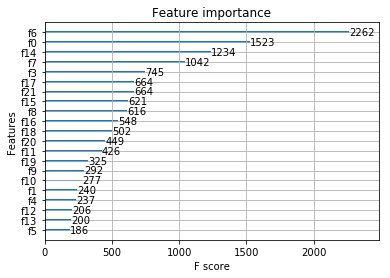

In [47]:
%matplotlib inline

xgb.plot_importance(best_model)

### Test Set Predict

In [51]:
train_df['Date'].max()

Timestamp('2015-07-31 00:00:00')

In [52]:
test_df['Date'].min()

'2015-08-01'

In [53]:
test_train_set_end_date = datetime.strptime('2015-07-31', '%Y-%m-%d')

test_feature_df = extract_train_feature_set(train_df, test_train_set_end_date)
test_avg_sales_3m = feature_last_3m_avg_sales(feature_df, test_train_set_end_date)
test_avg_sales_6m = feature_last_6m_avg_sales(feature_df, test_train_set_end_date)
test_avg_sales_1y = feature_last_1y_avg_sales(feature_df, test_train_set_end_date)
test_avg_customers_3m = feature_last_3m_avg_customers(feature_df, test_train_set_end_date)
test_avg_customers_6m = feature_last_6m_avg_customers(feature_df, test_train_set_end_date)
test_avg_customers_1y = feature_last_1y_avg_customers(feature_df, test_train_set_end_date)
test_store_day_sales_3m = feature_last_3m_store_day_sales(feature_df, test_train_set_end_date)
test_store_day_sales_6m = feature_last_6m_store_day_sales(feature_df, test_train_set_end_date)
test_store_day_sales_1y = feature_last_1y_store_day_sales(feature_df, test_train_set_end_date)
test_store_day_customers_3m = feature_last_3m_store_day_customers(feature_df, test_train_set_end_date)
test_store_day_customers_6m = feature_last_6m_store_day_customers(feature_df, test_train_set_end_date)
test_store_day_customers_1y = feature_last_1y_store_day_customers(feature_df, test_train_set_end_date)
test_sales_per_customer = feature_sales_per_customer(feature_df)


In [54]:
def feature_process(data):
    data = data.merge(store_df, on='Store', how='left')
    
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['CompetitionOpenMonth'] = data[['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']].apply(constructDatetime, axis=1)
    data['MonthAfterCompetition'] = data[['Date', 'CompetitionOpenMonth']].apply(calculateMonthDiff, axis=1)
    data['WeekOfYear'] = data['Date'].apply(lambda x: x.isocalendar()[1]) 
    data['MonthName'] = data['Date'].apply(lambda x: x.strftime('%b'))
    data['promo2Type'] = data[['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'WeekOfYear', 'MonthName']].apply(storePromo2Type, axis = 1)

    data = data.merge(test_avg_sales_3m, how='left', on='Store')
    data = data.merge(test_avg_sales_6m, how='left', on='Store')
    data = data.merge(test_avg_sales_1y, how='left', on='Store')
    data = data.merge(test_avg_customers_3m, how='left', on='Store')
    data = data.merge(test_avg_customers_6m, how='left', on='Store')
    data = data.merge(test_avg_customers_1y, how='left', on='Store')
    data = data.merge(test_store_day_sales_3m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
    data = data.merge(test_store_day_sales_6m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
    data = data.merge(test_store_day_sales_1y, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
    data = data.merge(test_store_day_customers_3m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
    data = data.merge(test_store_day_customers_6m, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
    data = data.merge(test_store_day_customers_1y, how='left', on=['Store', 'DayOfWeek', 'Promo', 'StateHoliday'])
    data = data.merge(test_sales_per_customer, how='left', on='Store')
    
    for column_name in categorical_columns:
        data[column_name] = data[column_name].astype('category')

    cat_columns = data.select_dtypes(['category']).columns
    data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
    
    return data

In [55]:
test_set = feature_process(test_df)

test_X = test_set[xgboost_feature_list].values
y_pred = np.exp(best_model.predict(test_X))
test_df['Sales'] = y_pred

In [56]:
test_df[['Id', 'Sales']].to_csv('kaggle_xgboost_v2_7.csv', index=False)